# Siamese Network Architecture 

##### Step1: Lets first import all libraries needed.

In [1]:
# -*- encoding: utf-8 -*-
import argparse
import torch
import torchvision.datasets as dsets
import random
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision import transforms
import pickle
import torch
import torch.nn as nn
%matplotlib inline


### Data Preprocessing
As we learned in theory part of Siamese Network, that as part of data preprocessing we need to create pairs.
1. 1 pair-> similar; y=0
2. 1 pair-> dissimilar; y=1

Note: We are using contrastive loss function.

#### Step2: To preporcess data, and create iterator for model, first create a Dataset Loader Class.

In [2]:
class Dataset(object):
    '''
    Class Dataset:
    Input: numpy values
    Output: torch variables.
    '''
    def __init__(self, x0, x1, label):
        self.size = label.shape[0] 
        self.x0 = torch.from_numpy(x0)
        self.x1 = torch.from_numpy(x1)
        self.label = torch.from_numpy(label)

    def __getitem__(self, index):
        return (self.x0[index],
                self.x1[index],
                self.label[index])

    def __len__(self):
        return self.size
    

##### Before creating an iterator, lets create pairs, and preprocess images in them.

In [3]:
def create_pairs(data, digit_indices):
    x0_data = []
    x1_data = []
    label = []
    n = min([len(digit_indices[d]) for d in range(3)]) - 1
    for d in range(3): # for MNIST dataset: as we have 10 digits
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            x0_data.append(data[z1]/255.) # Image Preprocessing Step
            x1_data.append(data[z2]/255.) # Image Preprocessing Step
            label.append(1)
            inc = random.randrange(1, 4)
            dn = (d + inc) % 3
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            x0_data.append(data[z1]/255.) # Image Preprocessing Step
            x1_data.append(data[z2]/255.) # Image Preprocessing Step
            label.append(0)

    x0_data = np.array(x0_data, dtype=np.float32) #[:10201]
#     print (x0_data.shape)
    x0_data = x0_data.reshape([-1, 3, 224, 224])
    x1_data = np.array(x1_data, dtype=np.float32) #[:10201]
    x1_data = x1_data.reshape([-1, 3, 224, 224])
    label = np.array(label, dtype=np.int32)
#     print (label.shape)
    return x0_data, x1_data, label

def create_iterator(data, label, batchsize, shuffle=False):
#     print ("max label", max(label))
    digit_indices = [np.where(label == i)[0] for i in range(max(label)+1)]
    x0, x1, label = create_pairs(data, digit_indices)
    ret = Dataset(x0, x1, label)
    return ret


###### create iterator: returns set of given batchsize for training purpose

# Loss Function: Contrastive Loss Function 

#### Step 3: Create Loss Function
As we know contrastive loss function consists of 2 parts:
![contrastive%20Loss.png](Images/contrastiveLoss.png)

1. for similar points: (1-y)*(distance_function)^2
2. for dissimilar points: y*{max(0,(m-distance_function^2)}

Here Distance Function is taken as euclidean distance, also known as root mean square.

In [4]:
def contrastive_loss_function(x0, x1, y, margin=1.0):
    # euclidean distance
    diff = x0 - x1
    dist_sq = torch.sum(torch.pow(diff, 2), 1)
    dist = torch.sqrt(dist_sq)
    mdist = margin - dist
    dist = torch.clamp(mdist, min=0.0)
    loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
    loss = torch.sum(loss) / 2.0 / x0.size()[0]
    return loss

def triplet_loss(positive, negative, anchor, size_average=True, margin=1.0):
    distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
    distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
    losses = F.relu(distance_positive - distance_negative + margin)
    return losses.mean() if size_average else losses.sum()


# Siamese Network Architecture

##### Step 4: Creating Siamese Network Architecture
For this first lets create a class called SiameseNetwork with 2 functions:
###### 1. forward_once: In forward_once pass through all layers and returns the output embeddings 
###### 2. forward: In forward, call forward_once 2 times for the Input pair given, and returns the embeddings obtained


As discussed in theory part of Siamese Network, we share parameters of twins, so we don't need to create explicitly both brances, we can just create one.

In [5]:
batchsize=8
import copy

class SiameseNetwork_DenseNet121(nn.Module):
    """
    Siamese neural network
    Modified from: https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7
    DenseNet 121 from Pytorch library
    """ 
    def __init__(self):
        super(SiameseNetwork_DenseNet121, self).__init__()
        self.cnn0 = torch.hub.load('pytorch/vision:v0.5.0', 'densenet121', pretrained=True)
        # map last layer from 1000 node outcome to three nodes
        #self.cnn0.fc = nn.Linear(1000, 3) # mapping input image to a 3D space

    def forward_once(self, x):
        output = self.cnn0(x)
        return output

    def forward(self, input0, input1):
        output0 = self.forward_once(input0)
        output1 = self.forward_once(input1)
        return output0, output1

In [6]:
import numpy as np
import os
import shutil
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

def extract_features(path):
    directory_lists=os.listdir(path)
    X=[]
    Y=[]
    count=0
    if ('.DS_Store' in directory_lists):
            directory_lists.remove('.DS_Store')
    for d in directory_lists:
        nest=os.listdir(path+"/"+d)
        if ('.DS_Store' in nest):
            nest.remove('.DS_Store')
        for f in nest:
            img = image.load_img(path+"/"+d+"/"+f, target_size=(224, 224))
            img_data = image.img_to_array(img)
            img_data = preprocess_input(img_data)
            img_data = np.expand_dims(img_data, axis=0)
            X.append(img_data)
            Y.append(count)
        count+=1
    X=np.array(X)
    y=np.array(Y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)         
    return X_train, X_test, y_train, y_test 

X_train, X_test, y_train, y_test = extract_features("./data/train/")
print (X_train.shape, y_train.shape)

Using TensorFlow backend.


(50, 1, 224, 224, 3) (50,)


##### We created an iterator above, here we will use it to create training and test set iterators. 

In [7]:
train_iter = create_iterator(X_train,y_train,batchsize)
test_iter = create_iterator(X_test,y_test,batchsize)

# call model
model = SiameseNetwork_DenseNet121()
# model = torch.load('./siamese.pth')
# model.eval()
learning_rate = 0.0001 # learning rate for optimization
momentum = 0.9 # momentum

# Loss and Optimizer
criterion =  contrastive_loss_function
#contrastive_loss_function # we will use contrastive loss function as defined above
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, verbose=True)
# creating a train loader, and a test loader.
train_loader = torch.utils.data.DataLoader(train_iter,batch_size=batchsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_iter,batch_size=2, shuffle=True)


Using cache found in /Users/sjadon/.cache/torch/hub/pytorch_vision_v0.5.0


## Let's Train our Model !!!

#### Step 5: Train Model for certain number of epochs. 

In [8]:
train_loss = []
epochs = 10
for epoch in range(epochs):
    total_loss = 0.0
    for batch_idx, (x0, x1, labels) in enumerate(train_loader):
        labels = labels.float()
        x0, x1, labels = Variable(x0), Variable(x1), Variable(labels)
        output1, output2 = model.forward(x0, x1)
        loss = criterion(output1, output2, labels)
        train_loss.append(loss.item())
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step(epoch)
    print('Epoch: {} \tLoss: {:.6f}'.format(epoch, total_loss*1.0/batchsize))
    if epoch%50==0:
        torch.save(model, './SiameseModified-epoch-%s.pth' % epoch)


Epoch: 0 	Loss: 516.365486
Epoch: 1 	Loss: 55.863125
Epoch: 2 	Loss: 16.121324
Epoch: 3 	Loss: 13.659343
Epoch: 4 	Loss: 6.045470
Epoch: 5 	Loss: 4.805836
Epoch: 6 	Loss: 3.631801
Epoch: 7 	Loss: 2.323724
Epoch: 8 	Loss: 2.255002
Epoch: 9 	Loss: 2.359111


# Let's Visualize our Plots

##### Step5: Lets Create all functions for plotting embeddings and loss function

##### Loss Function Plot

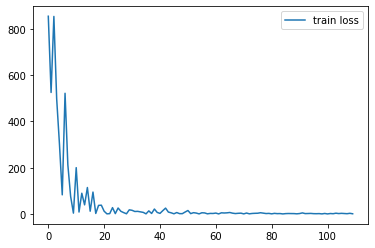

In [9]:
def plot_loss(train_loss,name="train_loss.png"):
    plt.plot(train_loss, label="train loss")
    plt.legend()
plot_loss(train_loss)
def plot_mnist(numpy_all, numpy_labels,name="./embeddings_plot.png"):
        c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
             '#ff00ff', '#990000', '#999900', '#009900', '#009999', '#000fff']
        for i in range(0,3):
            f = numpy_all[np.where(numpy_labels == i)]
            plt.plot(f[:, 0], f[:, 1], '.', c=c[i])
        plt.legend(['0', '1', '2'])
        plt.savefig(name)

### Plotting test-set Embeddings

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
0.34403411651925625


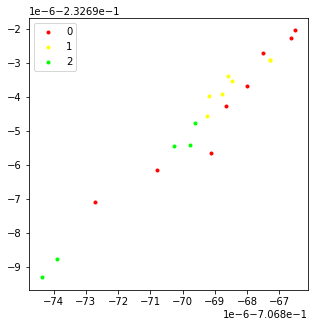

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
X_test = X_test/255.
y_test = np.array(y_test, dtype=np.int32)

def test_model(model):
        model.eval()
        all_ = []
        all_labels = []
        with torch.no_grad():
            for i in range(0, 20):
                x = Variable(torch.tensor(X_test[i].reshape([-1, 3, 224, 224])))
                y_t = np.array(y_test[i], dtype=np.int32)
                y = Variable(torch.tensor(y_t))
                output = model.forward_once(x)
                all_.extend(output.data.cpu().numpy().tolist())
                all_labels.append(y.data.cpu().numpy().tolist())

        numpy_all = np.array(all_)
        numpy_labels = np.array(all_labels)
        return numpy_all, numpy_labels

def testing_plots(model):
        dict_pickle={}
        numpy_all, numpy_labels = test_model(model)
        dict_pickle["numpy_all"]=numpy_all
        dict_pickle["numpy_labels"]=numpy_labels
        clusterer = KMeans(n_clusters=11)
        preds = clusterer.fit_predict(numpy_all)
        centers = clusterer.cluster_centers_
        score = silhouette_score(numpy_all, preds)
        print (score)
        plot_mnist(numpy_all, numpy_labels)

from sklearn.metrics import silhouette_samples, silhouette_score
from pylab import rcParams
rcParams['figure.figsize'] = 5, 5
testing_plots(model)